<a href="https://colab.research.google.com/github/honicky/character-extraction/blob/main/Character_Extractor_DistilBERT_NER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Character Extractor - DistilBERT NER

This notebook is part of an exploration of how to extract the names of characters from stories cheaply and easily. I am doing this as part of a little project to generate and co-author illustrated childrens stories.  One of the challenges for this problem is to generat consistent characters, so I am using it as an excuse to learn about different approaches including using various off-the-shelf models with manual and automated (DSPy) prompting, fine-tuning small models and just using god models like GTP4 or Claude Opus.

In this notebook I am using the DistilBERT NER (Named Entity Retrieval) model.  DistilBERT is a small (66 million parmaeter) model that can be used for classification and other tasks that do not require sequence-to-sequence generation.  NER is an area where small language models seem to do better than LLMs in the 3-14B range, so this is a great place to start.

## Getting started

DistilBERT-NER is easy to use, so lets fire it up and see how it works.  Note that I am using a small GPU for this notebook because we do some evals below, and I wanted to speed it up.  On the other hand, you can easily run this model on your CPU.

In [ ]:
!pip install datasets

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

tokenizer = AutoTokenizer.from_pretrained("dslim/distilbert-NER")
model = AutoModelForTokenClassification.from_pretrained("dslim/distilbert-NER").to("cuda")

ner = pipeline("ner", model=model, tokenizer=tokenizer)
example = "My name is Wolfgang and I live in Berlin"

ner_results = ner(example)
print(ner_results)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/669k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/966 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/261M [00:00<?, ?B/s]

[{'entity': 'LABEL_0', 'score': 0.9992238, 'index': 1, 'word': 'My', 'start': 0, 'end': 2}, {'entity': 'LABEL_0', 'score': 0.9994271, 'index': 2, 'word': 'name', 'start': 3, 'end': 7}, {'entity': 'LABEL_0', 'score': 0.99953353, 'index': 3, 'word': 'is', 'start': 8, 'end': 10}, {'entity': 'LABEL_1', 'score': 0.99110633, 'index': 4, 'word': 'Wolfgang', 'start': 11, 'end': 19}, {'entity': 'LABEL_0', 'score': 0.9994848, 'index': 5, 'word': 'and', 'start': 20, 'end': 23}, {'entity': 'LABEL_0', 'score': 0.987379, 'index': 6, 'word': 'I', 'start': 24, 'end': 25}, {'entity': 'LABEL_0', 'score': 0.9990946, 'index': 7, 'word': 'live', 'start': 26, 'end': 30}, {'entity': 'LABEL_0', 'score': 0.9990859, 'index': 8, 'word': 'in', 'start': 31, 'end': 33}, {'entity': 'LABEL_5', 'score': 0.9967968, 'index': 9, 'word': 'Berlin', 'start': 34, 'end': 40}]


# Load a data set to work with

I previously generated a bunch of stories and extracted the main characters using GPT4.  I've created a dataset on HuggingFace: `honicky/short_childrens_stories_with_labeled_character_names`.  This data set has a `story` feature, and a comma separated string with the main characters in a `characters` feature.



In [ ]:
from datasets import load_dataset

story_examples_dataset = load_dataset("honicky/short_childrens_stories_with_labeled_character_names")

# Perform a train-test split
train_test_split = story_examples_dataset['train'].train_test_split(test_size=0.2)

# Split the training set further to create a validation set
train_val_split = train_test_split['train'].train_test_split(test_size=0.25)

# Now, you have train, validation, and test sets
train_set = train_val_split['train']
validation_set = train_val_split['test']
test_set = train_test_split['test']

# You can see the number of examples in each set
print("Training set size:", len(train_set))
print("Validation set size:", len(validation_set))
print("Test set size:", len(test_set))

Generating train split:   0%|          | 0/2588 [00:00<?, ? examples/s]

Training set size: 1552
Validation set size: 518
Test set size: 518


In [ ]:
train_set["story"][:2]


[' Long, long ago in a small village nestled between two tall mountains, lived three best friends - Ali, Bina and Carlos. They were known as the Three Amigos of Harmony Village because they always looked out for each other and everyone else in their community. One day, while playing near the river, they found a little bird who had hurt its wing. Seeing the injured creature made them sad and they wanted to help it.\n\nAli suggested, "Let\'s take care of this bird until its wing gets better." So, they built a warm nest by the fireplace inside Ali\'s home. While nursing the bird back to health, they began discussing how animals often migrate to different places during seasonal changes. This sparked curiosity among the amigos, especially since they knew people also moved from country to country seeking safety or opportunities.\n\nBina asked her father, the wise village elder, "Why do some birds and people move to new lands?" Their elder explained, "When conditions become difficult, whether

# Display a story

The NER model creates a list of dictionaries that look like this:
```python
{
 'entity': 'LABEL_0',
 'score': 0.9992238,
 'index': 1,
 'word': 'My',
 'start': 0,
 'end': 2
}
 ```
 Each "word", which is actually a token that is mostly words, has a `entity` label.  The labels are a bit opaque, because the order doesn't match the information in the [model card](https://huggingface.co/dslim/distilbert-NER).

 Instead, I used the interface in huggingface and got this:  
 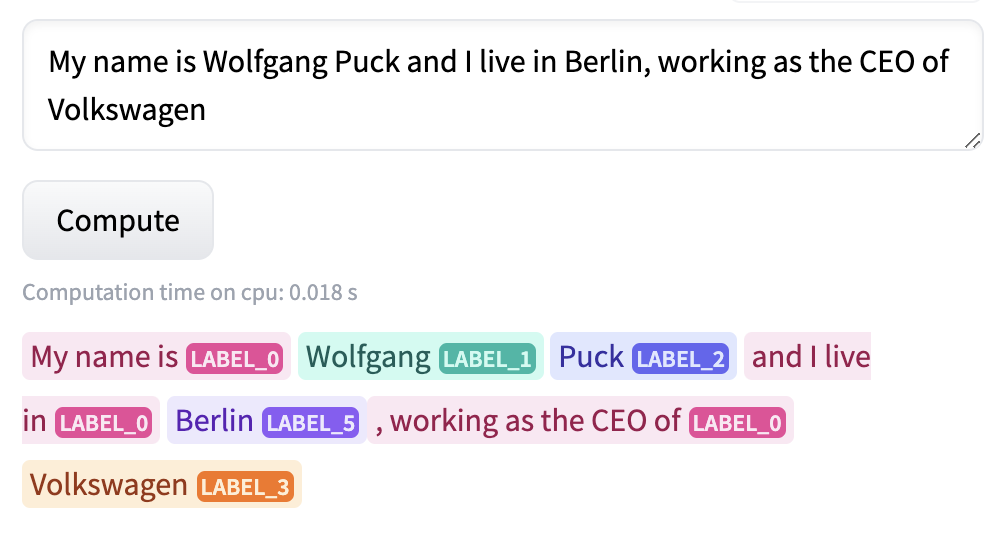


It looks like `LABEL_1` corresponds to `I-PER`, and `LABEL_2` corresponds to `B-PER`.  See the [Training Data](https://huggingface.co/dslim/distilbert-NER?text=My+name+is+Wolfgang+Puck+and+I+live+in+Berlin%2C+working+as+the+CEO+of+Volkswagen#training-data) section of the model card for details.

In any event, we can format our text kind of like hugging face by merging tokens into segments.

In [ ]:
def separate_tokens_by_type(tokens):
    result = []
    current_label = None
    current_text = []

    def add_to_result(label, text_list):
        if text_list:
            result.append((label, ''.join(text_list)))

    for token in tokens:
        word = token['word'].replace(r"\'", "'")
        label = token['entity']

        # Check if we need to switch to a new label
        if label != current_label:
            add_to_result(current_label, current_text)
            current_text = []
            current_label = label

        # Concatenate words according to the rules
        if word.startswith('##') or (len(word) == 1 and not word.isalnum()):
            # Add without space if it starts with ## or is punctuation
            if current_text:
                current_text[-1] += word.lstrip('##')
            else:
                current_text.append(word.lstrip('##'))
        else:
            # Add with a preceding space
            current_text.append(' ' + word if current_text else word)

    # Add the last accumulated text and label to the result
    add_to_result(current_label, current_text)

    return result


Lets get a story from the validation set and display it

In [ ]:
example_story = validation_set["story"][1]
example_characters = validation_set["characters"][1]
labeled_story = ner(example_story)

In [ ]:
segments = separate_tokens_by_type(labeled_story)

In [ ]:
from IPython.display import display, HTML

def print_labeled_text(segment_list):
  # Define colors for each label
  label_colors = {
      'LABEL_0': 'lightblue',
      'LABEL_1': 'lightgreen',
      'LABEL_2': 'lightcoral',
      'LABEL_3': 'wheat',
      'LABEL_4': 'lightpink',
      'LABEL_5': 'lavender',
      'LABEL_6': 'lightgrey',
      'LABEL_7': 'khaki',
      'LABEL_8': 'aquamarine',
  }

  # Create HTML string for displaying with highlights
  html_output = "<p style='font-size:16px;'>"

  for label, text in segment_list:

    color = label_colors[label]  # Default color black if label not found
    html_output += f"<span style='background-color:{color};'>{text}</span> "

  html_output += "</p>"

  # Display in Jupyter Notebook
  display(HTML(html_output))

In [ ]:
print_labeled_text(segments)

## Extract the names

Ok, now we can extract the names using NER, combine the name tokens and create a set from them.  We use a special class called `NameSet` that does some minor cleanup. In particular, it looks for name substrings and assumes they are the same name.

In [ ]:
import string

def strip_punctuation_and_whitespace(s):
    # Define the characters to strip: punctuation + whitespace
    strip_chars = string.punctuation + string.whitespace

    # Strip the characters from both ends of the string
    return s.strip(strip_chars)

In [ ]:
class NameSet:
    def __init__(self):
        self.names = set()

    def add_name(self, new_name):
        to_remove = set()
        for name in self.names:
            if new_name in name:
                return
            if name in new_name:
                to_remove.add(name)

        # Remove all names that are substrings of the new name
        self.names.difference_update(to_remove)

        # Add the new name to the set
        self.names.add(new_name)

    def __repr__(self):
        return f"{self.names}"


def extract_names(token_segments):
  current_name = None
  names = NameSet()
  for label, text in token_segments:
    text = strip_punctuation_and_whitespace(text)

    if label == "LABEL_1":
      current_name = text
    elif label == "LABEL_2":
      if not current_name:
        # print("warning: unexpected LABEL_2")
        continue
      current_name += " " + text
    else:
      if current_name:
        names.add_name(current_name)
      current_name = None

  return names


In [ ]:
extract_names(segments)

{'Aleksandr Prudnikov', 'Sasha'}

In [ ]:
set(example_characters.split(","))

{'Aleksandr Prudnikov', 'Sasha'}

# Extract the names from stories in our validation set

We don't need to train this model, but we will still use the validation set, so that we are consistent across models.

Now we can extract the names from each story and compare them to the names that GPT4 extracted.  I inspected some of the names from the GTP4 set manually, and didn't find many important mistakes, but it is also not perfect.  We can use it as a baseline though.

In [ ]:
def get_name_label_set(label):
  return set(label.split(","))

def extract_name_label_set(story):
  return extract_names(separate_tokens_by_type(ner(story))).names


In [ ]:
import pandas as pd
validation_set_pd = pd.DataFrame(validation_set)

In [ ]:
name_label_set = validation_set_pd.characters[:200].apply(get_name_label_set)

In [ ]:
extracted_name_set = validation_set_pd.story[:200].apply(extract_name_label_set)

Looks like we can do something like 100 stories per minute with a T4 GPU


# Evaluate our performance

We will use mean accuracy, precision and recall statistics to evaluate our performance. We have slightly weird data structures, so we will use our own custom functions rather than try to squeeze them into scikit-learn's versions.

In [ ]:
import numpy as np

def accuracy(left, right):
  return np.mean(left == right)

def precision(true_labels, predicted_labels):
  vectorized_precision = np.vectorize(lambda true_labels, predicted_labels: 0 if len(predicted_labels) == 0 else len(true_labels & predicted_labels)/len(predicted_labels) )
  return np.mean(vectorized_precision(true_labels, predicted_labels))

def recall(true_labels, predicted_labels):
  vectorized_recall = np.vectorize(lambda true_labels, predicted_labels: len(true_labels & predicted_labels)/len(true_labels) )
  return np.mean(vectorized_recall(true_labels, predicted_labels))



In [ ]:
distilbert_ner_evals = {
    "accuracy": accuracy(name_label_set, extracted_name_set),
    "precision": precision(name_label_set, extracted_name_set),
    "recall": recall(name_label_set, extracted_name_set),
}
distilbert_ner_evals

{'accuracy': 0.33, 'precision': 0.7336993145743146, 'recall': 0.736375}

This isn't amzing performance.  We could definitely do better by cleaning the data up better, but all of the models will probably need some cleanup, so I'll try that later.

In [ ]:
errors_df = (
    name_label_set
    .rename("true_labels")
    .to_frame()
    .join(extracted_name_set.rename("predicted_labels"))
)
errors_df = errors_df[errors_df.true_labels != errors_df.predicted_labels]


In [ ]:
with pd.option_context('display.max_rows', None):
    display(errors_df)


,true_labels,predicted_labels
0,"{Herodotus, Mr. Solon, Timmy, King Darius, Gen...","{s Datis, Solon, Timmy, Hero, King Darius, Art..."
2,"{Mr. Newton, Alan}","{Newton, Alan}"
4,"{Lenny, Walter, Lola}","{Lenny, Lena, Leno, Walter, Lola}"
5,"{Timmy's mom, Timmy, Carl Smith}","{Mom, Timmy, Carl Smith}"
6,"{Molly, Dr. Smith}","{Molly, Dr Smith}"
8,"{Mr. Green, Jenny, Tim}","{Jenny, Tim}"
11,"{Chippy Squirrel, Mayor Hooty Owl, Grumpy Gori...","{Hooty Owl, Chippy Squirrel, Tortoise}"
12,"{Bobby, Lily, Bette Midler}","{Bobby, Mommy, Lily, Bette Midler}"
13,"{Katie, John Howard, news reporter koala, Wally}","{Katie, la, John Howard, Wally}"
15,"{Misha, friendly aliens, Natasha}","{Misha, Natasha}"


Looks like there are a few types of errors:
* Omissions of partial names: `{"Timmy's mom", 'Timmy', 'Carl Smith'}` vs `{'Mom', 'Timmy', 'Carl Smith'}`
* Omissions of titles: `{'Mr. Newton', 'Alan'}` vs `	{'Newton', 'Alan'}`
* Omissions of epithets: `{'Oliver the Owl', 'Emma the Elephant'}` vs `{'Emma', 'Oliver'}`
* Addition of non-names or other characters: `{'Beyoncé', 'LaTavia', 'Kelly'}` vs `{'Beyoncé', 'Girl', 'LaTavia', 'Kelly'}`
* ...

While we could devise heuristics to deal with some of these things, I'd rather the model do a better job.  A good LLM will be able to understand that Mr. Foo and George Foo are the same person, for example.